In [2]:
import numpy
import matplotlib
from matplotlib import pyplot
import tensorflow as tf
import cv2
import os
from glob import glob
pyplot.rcParams['figure.figsize'] = [15, 10]

In [3]:
print(f'numpy     : {numpy.__version__}')
print(f'matplotlib: {matplotlib.__version__}')
print(f'tensorflow: {tf.__version__}')
print(f'opencv    : {cv2.__version__}')

numpy     : 1.26.4
matplotlib: 3.9.2
tensorflow: 2.10.1
opencv    : 4.10.0


In [4]:
def load_image(filename: str):
    image = cv2.imread(filename)
    one_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    one_img = cv2.resize(one_img, (256, 256))
    w = (one_img.shape[1]//32)*32
    h = (one_img.shape[0]//32)*32
    one_img = one_img[:h, :w].astype(dtype=numpy.float32)/255.0
    one_img.shape=(1, h, w, 3)
    return one_img

In [5]:
model_greed: tf.keras.Model = tf.keras.models.load_model('cat_vs_dog_greed_model', compile=False)
model_greed.trainable = False
model_greed.compile()

In [6]:
model_cnn: tf.keras.Model = tf.keras.models.load_model('cat_vs_dog_cnn_model', compile=False)
model_cnn.trainable = False
model_cnn.compile()

In [7]:
model_mixer: tf.keras.Model = tf.keras.models.load_model('cat_vs_dog_mixer_model', compile=False)
model_mixer.trainable = False
model_mixer.compile()

In [8]:
model_vgg19: tf.keras.Model = tf.keras.models.load_model('cat_vs_dog_vgg19_model', compile=False)
model_vgg19.trainable = False
model_vgg19.compile()

In [9]:
model_resnet: tf.keras.Model = tf.keras.models.load_model('cat_vs_resnetV2__model', compile=False)
model_resnet.trainable = False
model_resnet.compile()

In [10]:
classes = ['Cat', 'Dog']

1/1 [==============================] - 1s 985ms/step
Greed:  [[9.9999964e-01 3.5274434e-07]] Cat
CNN  : [[9.999999e-01 7.064482e-08]] Cat
Mixer: [[0.9833794  0.01662062]] Cat
VGG19: [[0.8156693  0.16451879]] Cat
ResNet: [[9.9993622e-01 6.3818254e-05]] Cat


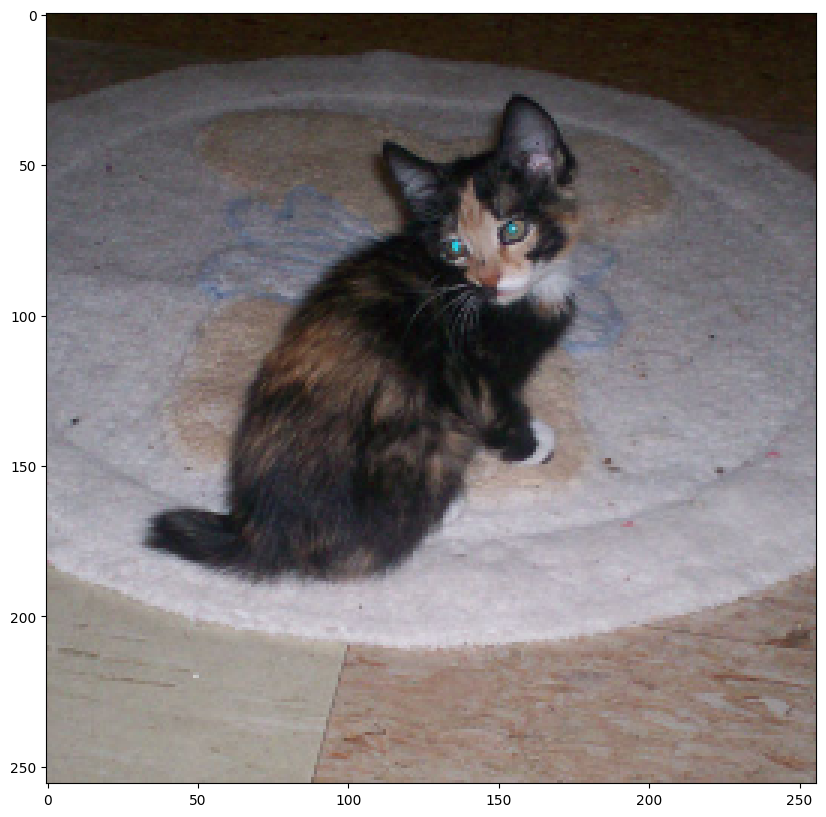

In [11]:
image_filename = './data/PetImages/Cat/10050.jpg'
# image_filename = './data/PetImages/Dog/311.jpg'
img = load_image(image_filename)
img_vgg19 = cv2.resize(img[0], (224, 224))
img_vgg19.shape = (1, img_vgg19.shape[0], img_vgg19.shape[1], 3)
target_greed = model_greed.predict(img)
target_cnn   = model_cnn.predict(img)
target_mixer = model_mixer.predict(img)
target_vgg19 = model_vgg19.predict(img_vgg19)
target_resnet = model_resnet.predict(img_vgg19)
print('Greed: ', target_greed, classes[target_greed.argmax()])
print('CNN  :', target_cnn, classes[target_cnn.argmax()])
print('Mixer:', target_mixer, classes[target_mixer.argmax()])
print('VGG19:', target_vgg19, classes[target_vgg19.argmax()])
print('ResNet:', target_resnet, classes[target_resnet.argmax()])
pyplot.imshow(img[0])
pyplot.show()

In [12]:
def process(model: tf.keras.Model, 
            image: numpy.ndarray, 
            weight_class=5.0, weight_blur=1.0, weight_sharpness=0.99,
            err_method='abs', 
            filename_video='transform.avi',
            iterations = 3000):
    history = list()
    # new_model = keras.models.Sequential()
    # for layer in model.layers[:-1]: # Exclude the last layer
    #     new_model.add(layer)
    # new_model.add(tf.keras.layers.Activation('linear', name='last_activation'))
    model.layers[-1].activation = tf.keras.activations.linear
    target_out: numpy.ndarray = model.predict(image)
    print('target_out.shape', target_out.shape)
    image_init = image.copy()
    mean_color = numpy.mean(image_init, axis=(1, 2), keepdims=True) #numpy.array([0, 0, 0])# 
    # image_init_blured = cv2.blur((image_init[0]*255).astype(dtype=numpy.uint8), (7, 7))
    # for _ in range(50):
    #     image_init_blured = cv2.blur(image_init_blured, (7, 7))
    image_init_blured = image.copy()
    image_init_blured[0, :, :] = mean_color
    print('image_init_blured.shape', image_init_blured.shape)
    # cv2.imshow('image_init_blured', image_init_blured)
    # image_init_blured = image_init_blured.astype(dtype=numpy.float32)/255.0
    # image_init_blured.shape = (1, image_init_blured.shape[0], image_init_blured.shape[1], 3)
    video_writer = cv2.VideoWriter(filename_video, 
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         30, (512, 256))
    frame_writer = numpy.zeros(shape=(256, 512, 3), dtype=numpy.uint8)
    # High frequency filter
    def make_tf_filter_3x3(filter_3x3):
        filter_tf = numpy.zeros(shape=(3, 3, 3, 3), dtype=numpy.float32)
        filter_tf[:, :, 0, 0] = filter_3x3
        filter_tf[:, :, 1, 1] = filter_3x3
        filter_tf[:, :, 2, 2] = filter_3x3
        return tf.constant(value=filter_tf, dtype=tf.float32)

    def make_tf_filter_5x5(filter_5x5):
        filter_tf = numpy.zeros(shape=(5, 5, 3, 3), dtype=numpy.float32)
        filter_tf[:, :, 0, 0] = filter_5x5
        filter_tf[:, :, 1, 1] = filter_5x5
        filter_tf[:, :, 2, 2] = filter_5x5
        return tf.constant(value=filter_tf, dtype=tf.float32)

    # Filters 
    sobel_h = numpy.array([[0.2, 0.6, 0.2],[0.0, 0.0, 0.0],[-0.2,-0.6,-0.2]], dtype=numpy.float32)
    sobel_h = make_tf_filter_3x3(sobel_h)
    sobel_w = numpy.array([[0.2, 0.0,-0.2],[0.6, 0.0,-0.6],[ 0.2, 0.0,-0.2]], dtype=numpy.float32)
    sobel_w = make_tf_filter_3x3(sobel_w)

    # sobel_h = numpy.array([[0.1, 0.2, 0.4, 0.2, 0.1], [0.1, 0.1, 0.2, 0.1, 0.1], [0.0, 0.0, 0.0, 0.0, 0.0], [-0.1,-0.1,-0.2,-0.1,-0.1], [-0.1,-0.2,-0.4,-0.2,-0.1]], dtype=numpy.float32)
    # sobel_h = make_tf_filter_5x5(sobel_h)
    # sobel_w = numpy.array([[0.1, 0.1, 0.0,-0.1,-0.1], [0.2, 0.1, 0.0,-0.1,-0.2], [0.4, 0.2, 0.0,-0.2,-0.4], [ 0.2, 0.1, 0.0,-0.1,-0.2], [ 0.1, 0.1, 0. ,-0.1,-0.1]], dtype=numpy.float32)
    # sobel_w = make_tf_filter_5x5(sobel_w)

    if err_method=='abs':
        err_type = tf.abs
    else:
        err_type = tf.square

    optimaser = tf.keras.optimizers.Adam(name='optimaser', learning_rate=0.0025)
    alpha_frame = None
    class_name = None
    alpha_channel_tf = tf.Variable(numpy.ones(shape=(1, image_init.shape[1], image_init.shape[2], 3), dtype=numpy.float32), trainable=True)
    # alpha_channel_tf = alpha_channel_tf + tf.random.uniform(shape=(1, image_init.shape[1], image_init.shape[2], 3), minval=0.0, maxval=1.0, dtype=tf.float32)
    image_init_tf = tf.constant(image_init, dtype=numpy.float32)
    image_blured_tf = tf.constant(image_init_blured, dtype=numpy.float32)

    for _ in range(iterations//10):
        
        for _ in range(10):
            with tf.GradientTape() as t:
                image_analyzed = tf.add(tf.multiply(image_blured_tf, 1.0-alpha_channel_tf), tf.multiply(image_init_tf, alpha_channel_tf))
                f = model(image_analyzed)
                sh = tf.nn.conv2d(alpha_channel_tf, filters=sobel_h, strides=(1,1), padding='VALID')
                sw = tf.nn.conv2d(alpha_channel_tf, filters=sobel_w, strides=(1,1), padding='VALID')
                sh = err_type(sh)
                sw = err_type(sw)
                sh = tf.reduce_mean(sh)
                sw = tf.reduce_mean(sw)
                sr = tf.reduce_mean(tf.square(alpha_channel_tf))
                loss_markers = tf.reduce_mean(tf.square(target_out-f))*weight_class
                loss_sharpness = ((sh+sw)*weight_sharpness+sr*(1.0-weight_sharpness))*weight_blur
                loss = loss_markers + loss_sharpness
            history.append( [loss_markers.numpy(), loss_sharpness.numpy()] )
            gradients = t.gradient(loss, alpha_channel_tf)
            # alpha_channel_tf.assign_sub(gradients)
            alpha_channel_tf.assign(tf.clip_by_value(alpha_channel_tf, 0.0, 1.0))
            optimaser.apply_gradients(zip([gradients], [alpha_channel_tf]))
        class_name = classes[numpy.argmax(f.numpy()[0])]
        # class_of_init = model(image_init)
        # print(tf.reduce_max(gv).numpy())
        frame = (image_analyzed.numpy()[0]*255).astype(dtype=numpy.uint8)
        # attention_map = alpha_channel_tf.numpy()[0]*255/alpha_channel_tf.numpy().max()
        # attention_map = cv2.blur(attention_map, (7, 7))
        # attention_map = attention_map.mean(axis=2).astype(dtype=numpy.uint8)
        # # print('attention_map.type', attention_map.dtype)
        # # print('frame.type', frame.dtype)
        # frame[:, :, 0] = cv2.addWeighted(frame[:, :, 0], 0.5, attention_map, 0.5, 0)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)        
        
        # cv2.imshow('processing_image', frame)
        # cv2.imshow('alpha_channel', (alpha_channel_tf.numpy()[0]*255).astype(dtype=numpy.uint8))
        frame = cv2.resize(frame, (256, 256))
        alpha_frame = (alpha_channel_tf.numpy()[0]*255/alpha_channel_tf.numpy()[0].max()).astype(dtype=numpy.uint8)
        alpha_frame = cv2.resize(alpha_frame, (256, 256))
        alpha_frame = cv2.cvtColor(alpha_frame, cv2.COLOR_RGB2BGR)
        frame_writer[:, :256, :] = frame
        frame_writer[:, 256:, :] = alpha_frame
        cv2.imshow('processing_image', frame_writer)
        cv2.putText(frame, f'{class_name}: {numpy.max(f.numpy()[0]):.4f}/{numpy.max(target_out[0]):.4f}', (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0))
        video_writer.write(frame_writer)
        K = cv2.waitKey(1)
        if K==27:
            break
    video_writer.release()
    del video_writer
    cv2.destroyAllWindows()

    pyplot.subplot(1, 3, 1)
    pyplot.imshow(image[0])
    pyplot.subplot(1, 3, 2)
    pyplot.imshow(cv2.cvtColor(frame_writer[:, 256:, :], cv2.COLOR_RGB2BGR)) #, vmin=0.0, vmax=1.0)
    pyplot.subplot(1, 3, 3)
    pyplot.imshow(cv2.Canny(frame_writer[:, :256, :], 10.0, 20.0)) #
    pyplot.show()
    print(f'{class_name}: {numpy.max(f.numpy()[0]):.4f}/{numpy.max(target_out[0]):.4f}')
    return numpy.array(history)
# pyplot.imshow(class_of_init[0])
# pyplot.show()

Processing VGG19 model...
1/1 [==============================] - 0s 23ms/step
target_out.shape (1, 2)
image_init_blured.shape (1, 224, 224, 3)


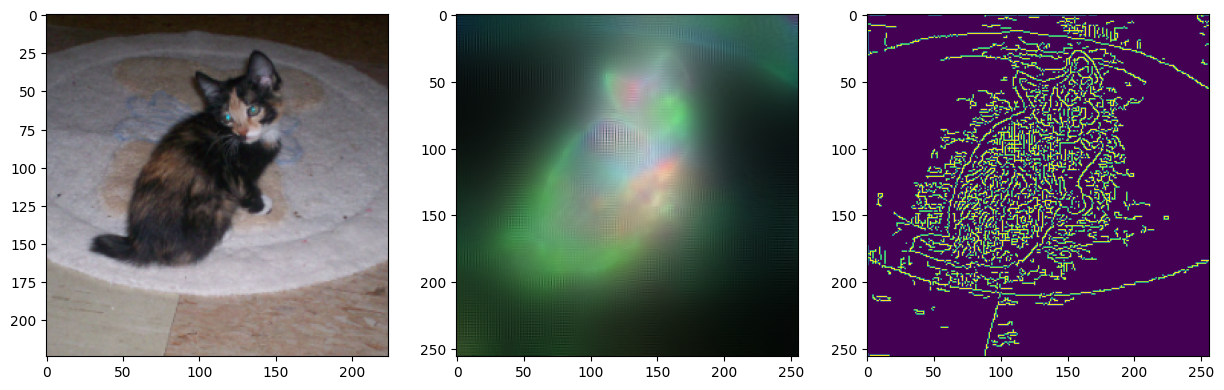

Cat: 0.3976/0.8157
(5000, 2)


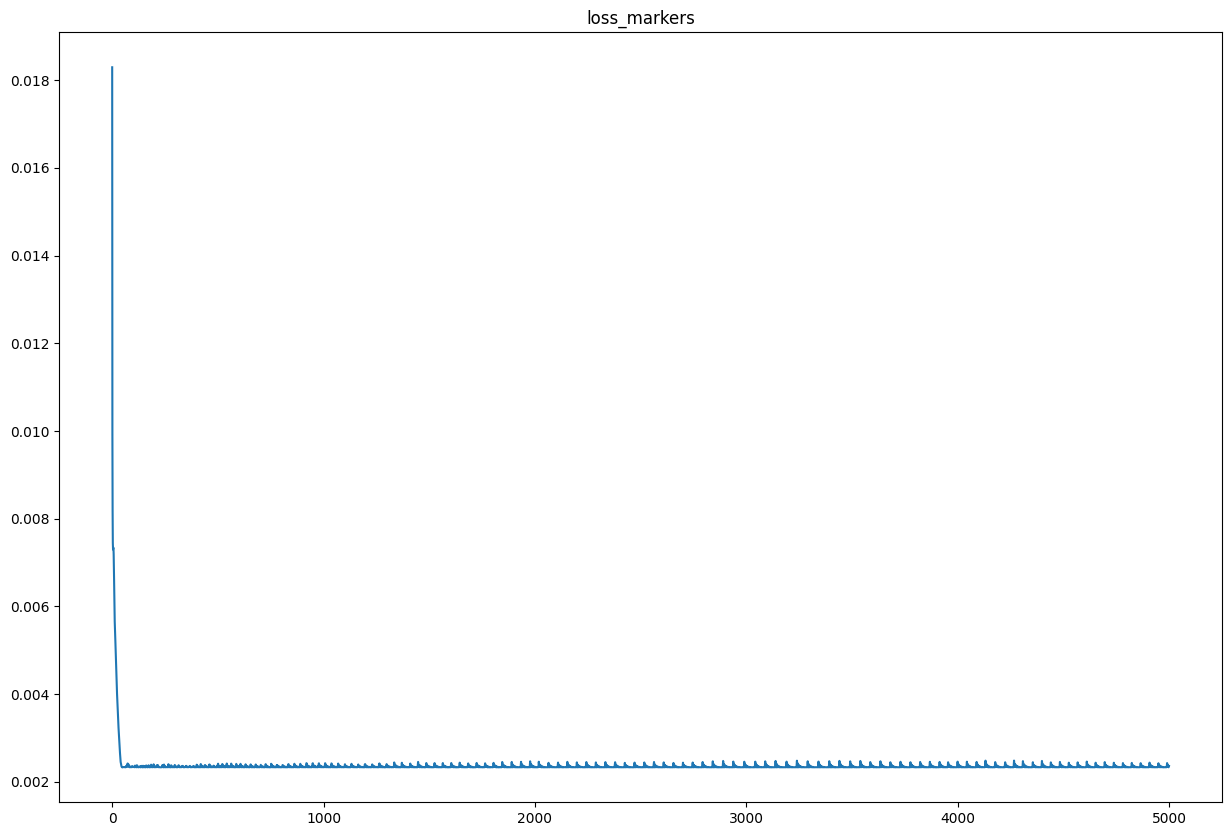

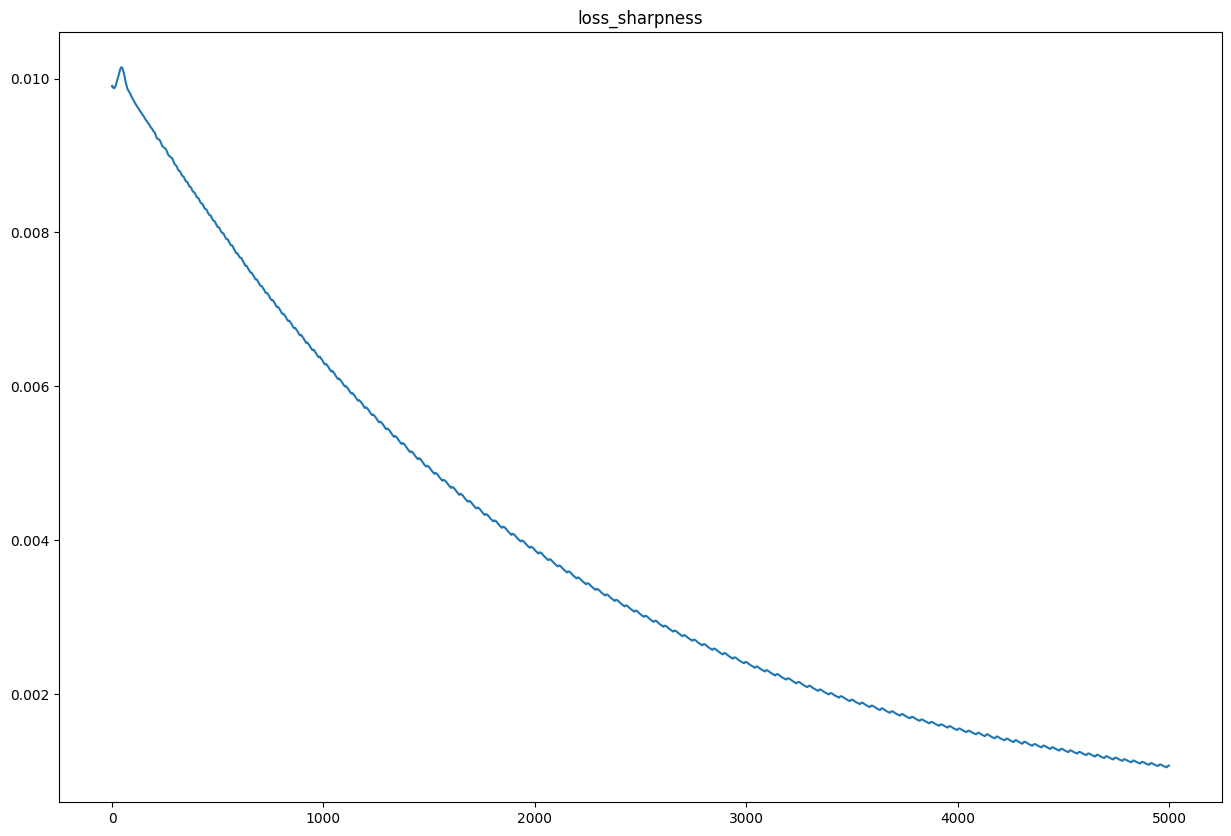

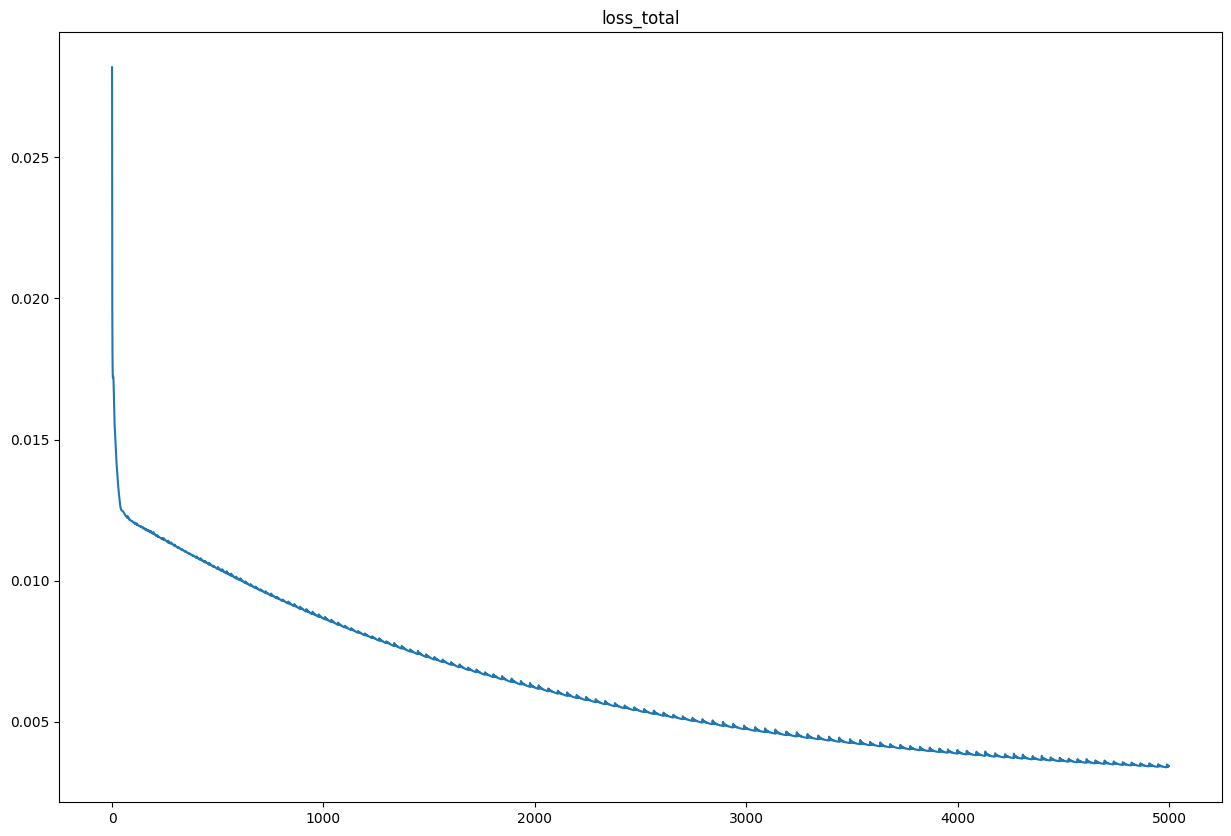

In [13]:
print('Processing VGG19 model...')
history = process(model=model_vgg19, image=img_vgg19, \
                    # target_out=numpy.array(target_vgg19, numpy.float32), \
                    weight_class=0.01, weight_blur=0.99, err_method='square', \
                    filename_video='vgg19_transform_2.avi',
                    iterations=5000)

### Plot history
print(history.shape)
pyplot.plot(history[:, 0])
pyplot.title('loss_markers')
pyplot.show()
pyplot.plot(history[:, 1])
pyplot.title('loss_sharpness')
pyplot.show()
pyplot.plot(history[:, 0]+history[:, 1])
pyplot.title('loss_total')
pyplot.show()


Processing Greed model...
1/1 [==============================] - 0s 28ms/step
target_out.shape (1, 2)
image_init_blured.shape (1, 256, 256, 3)


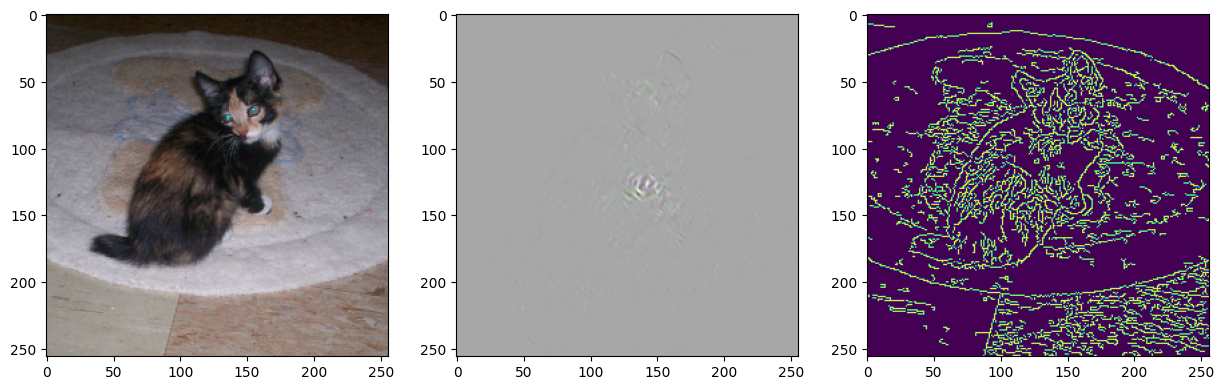

Cat: 1.0000/1.0000


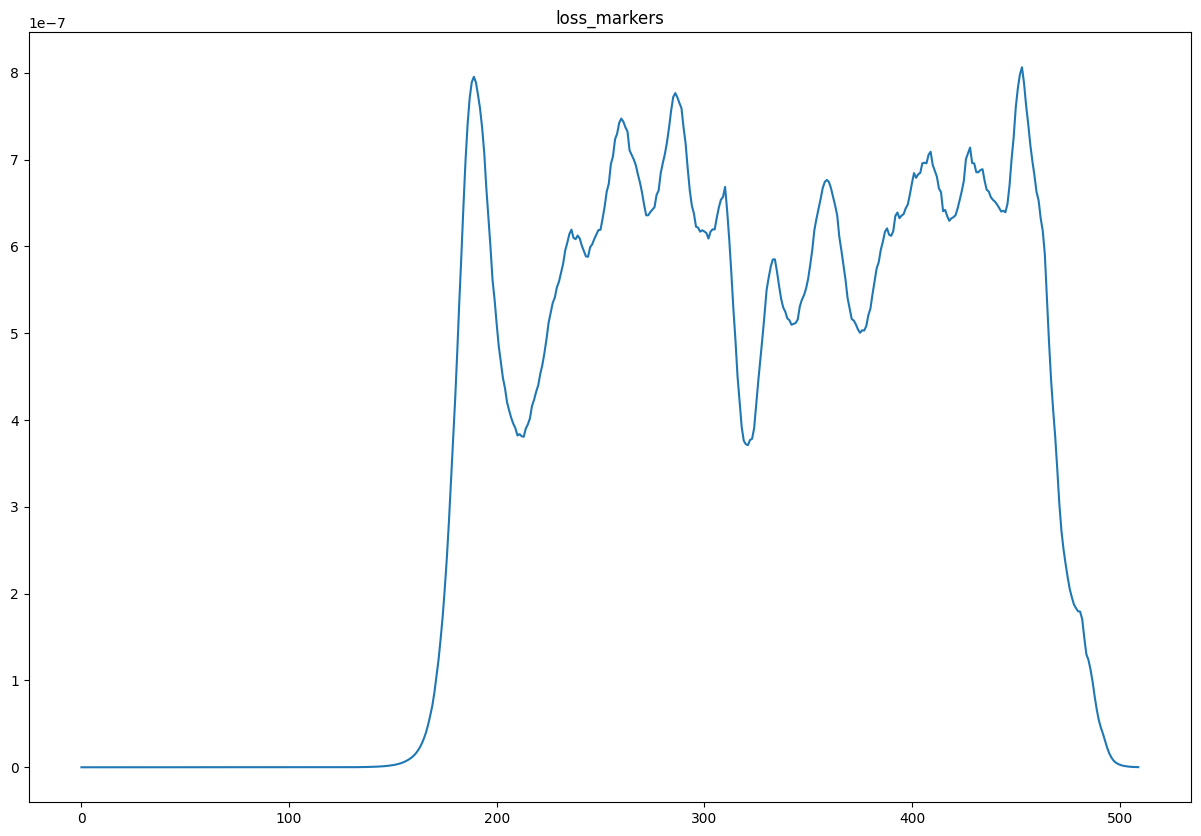

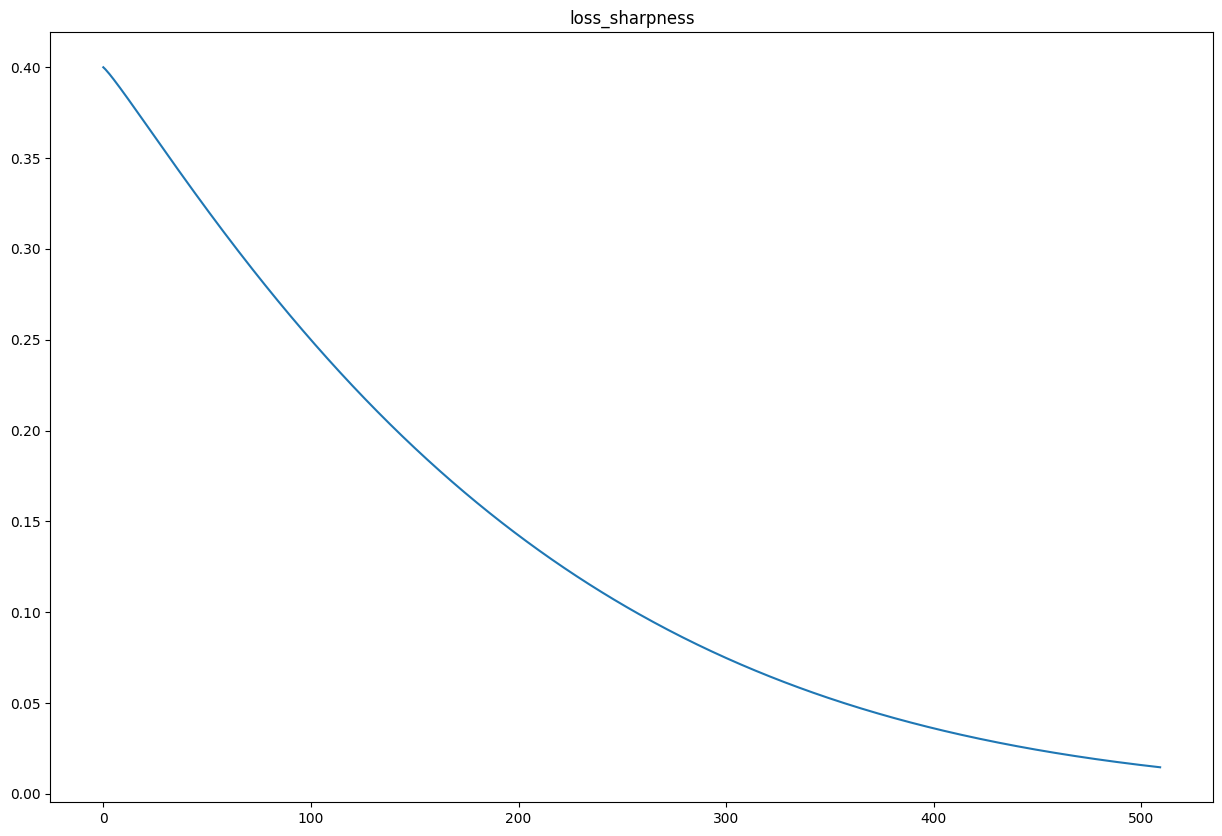

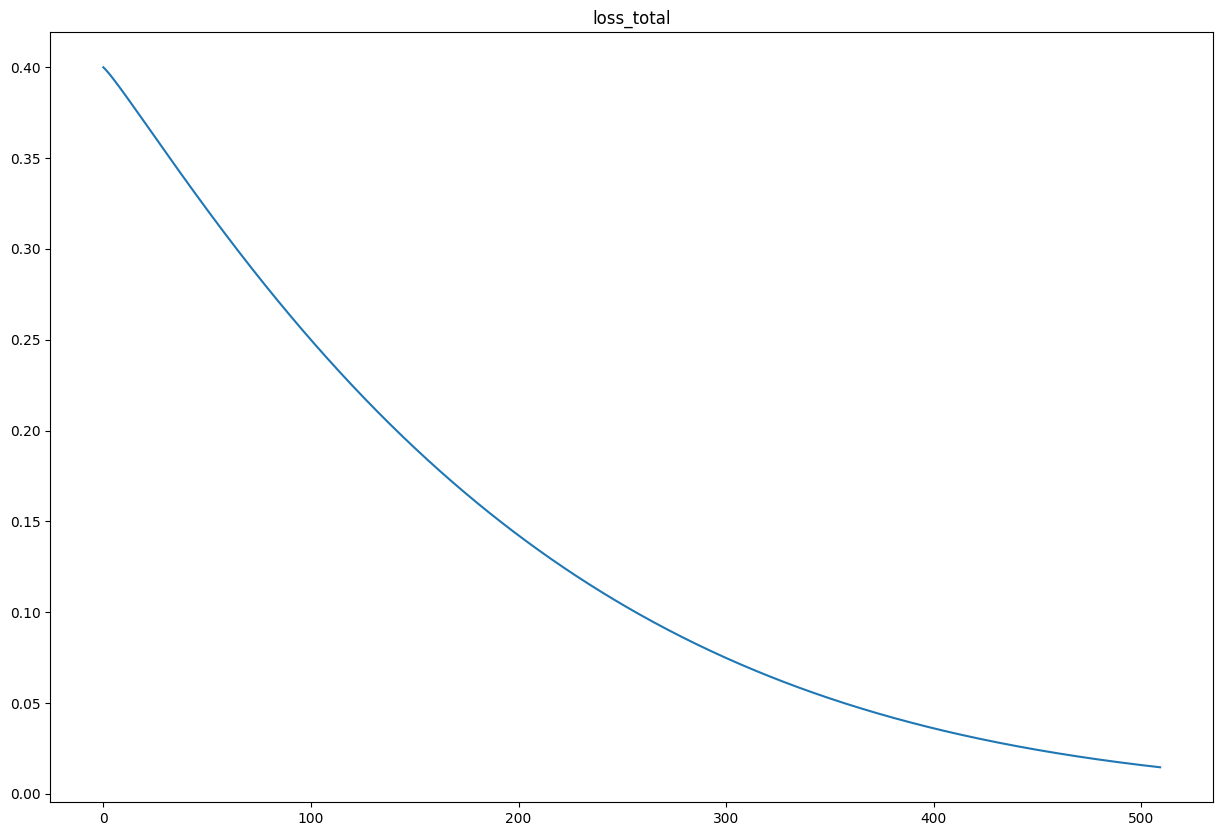

In [ ]:
print('Processing Greed model...')
history = process(model=model_greed, image=img, \
                    # target_out=numpy.array(target_greed, numpy.float32), \
                    weight_class=0.5, weight_blur=0.5, weight_sharpness=0.2, err_method='square', \
                    filename_video='greed_transform_2.avi',
                    iterations=500)

### Plot history

pyplot.plot(history[:, 0])
pyplot.title('loss_markers')
pyplot.show()
pyplot.plot(history[:, 1])
pyplot.title('loss_sharpness')
pyplot.show()
pyplot.plot(history[:, 0]+history[:, 1])
pyplot.title('loss_total')
pyplot.show()

Processing Mixer model...
1/1 [==============================] - 0s 57ms/step
target_out.shape (1, 2)
image_init_blured.shape (1, 256, 256, 3)


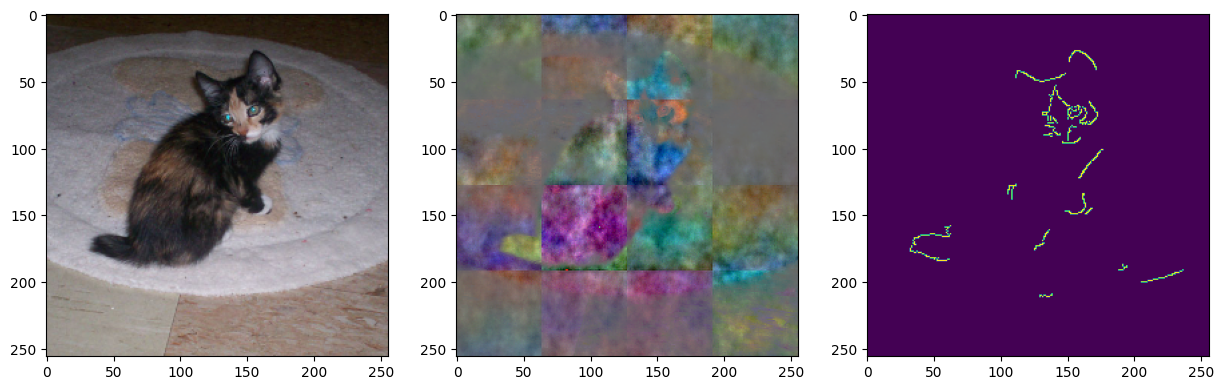

Cat: 0.9682/0.9834


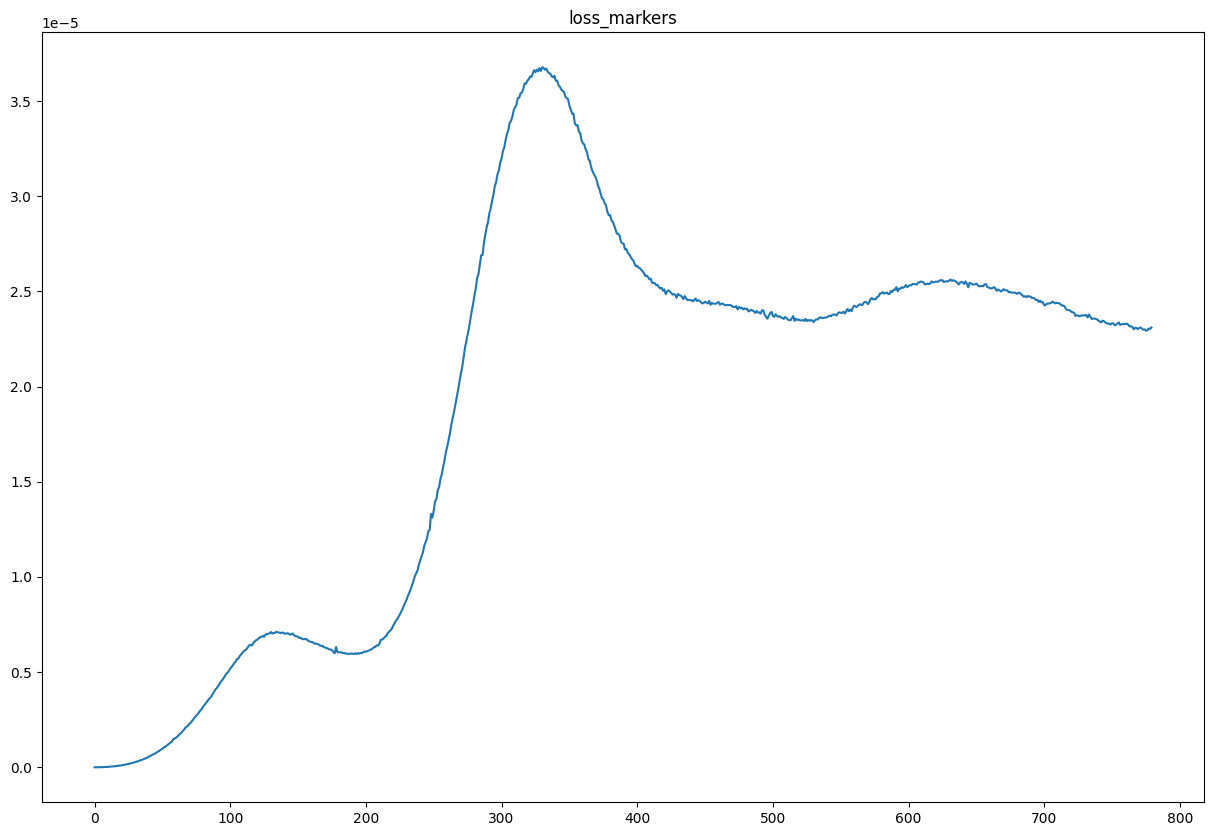

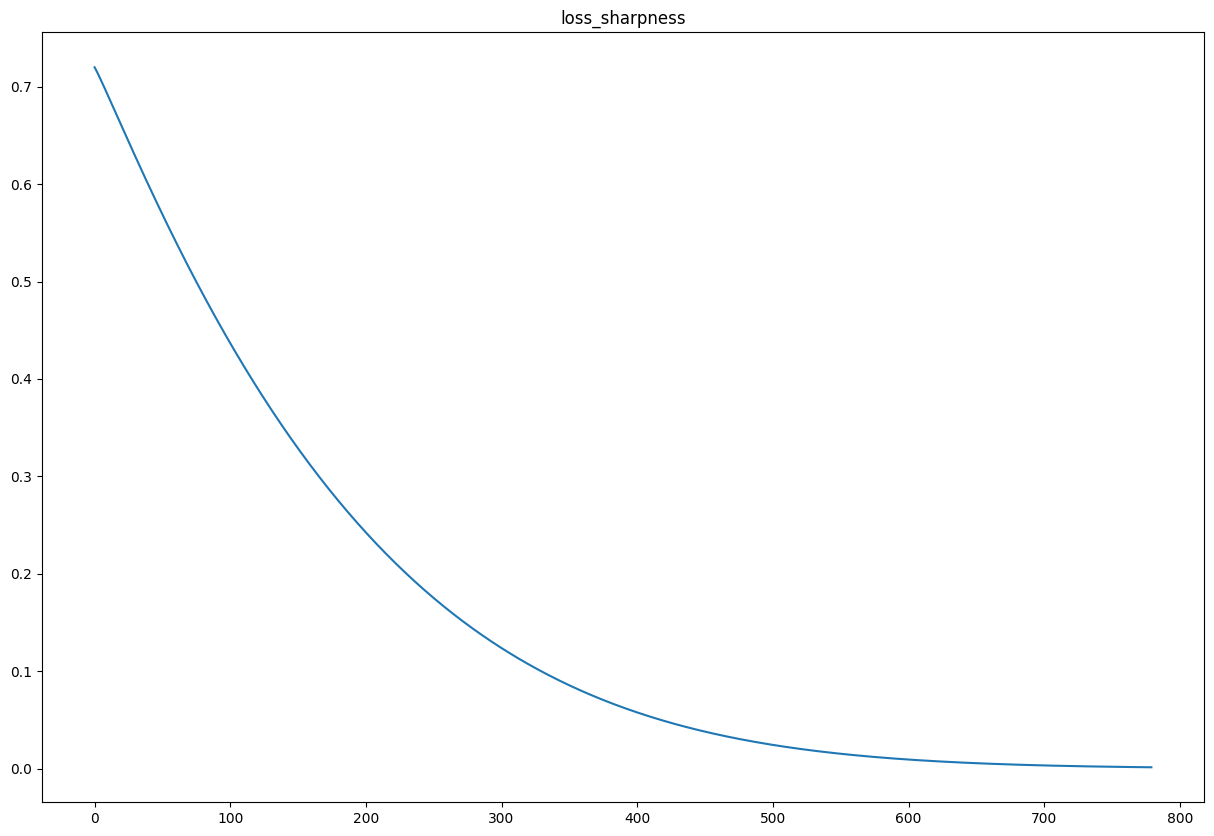

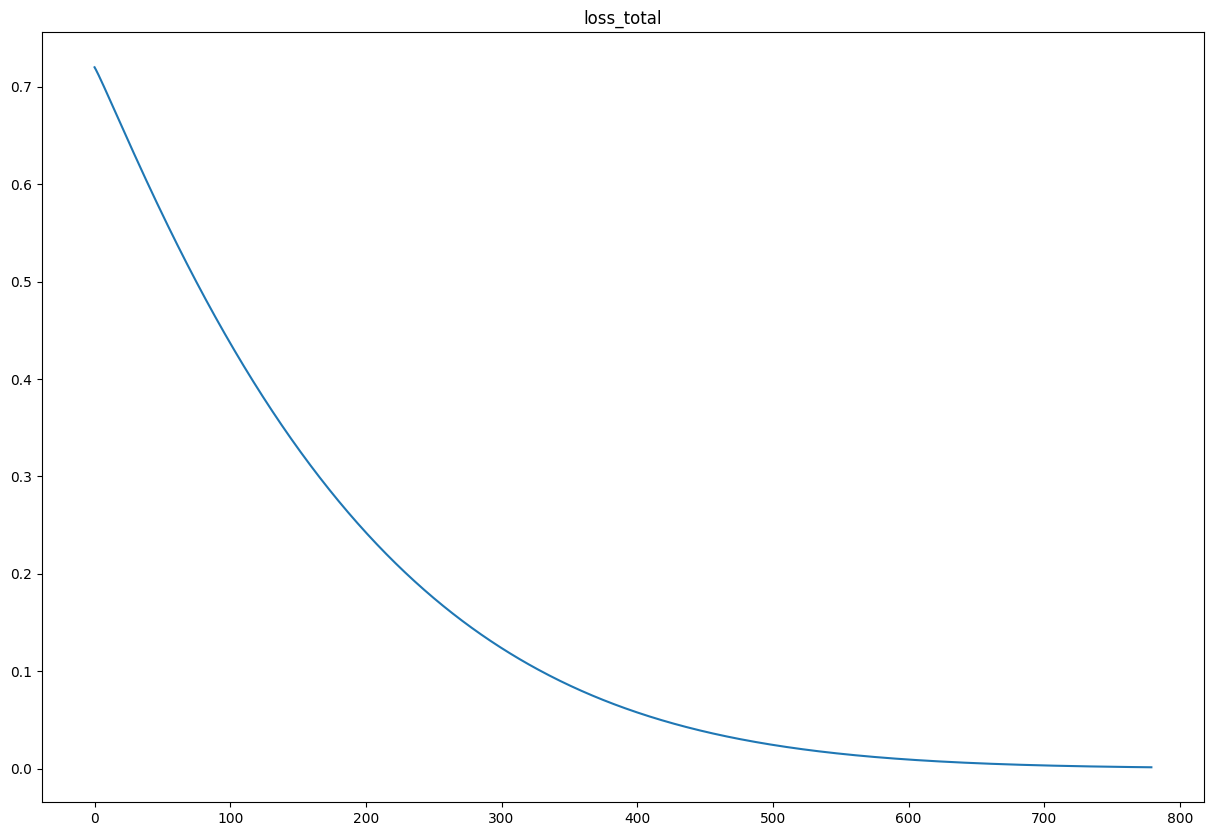

In [ ]:
print('Processing Mixer model...')
history = process(model=model_mixer, image=img, \
                    # target_out=numpy.array(target_mixer, numpy.float32), \
                    weight_class=0.1, weight_blur=0.9, weight_sharpness=0.2, \
                    err_method='square', \
                    filename_video='mixer_transform_2.avi',
                    iterations=800)

### Plot history

pyplot.plot(history[:, 0])
pyplot.title('loss_markers')
pyplot.show()
pyplot.plot(history[:, 1])
pyplot.title('loss_sharpness')
pyplot.show()
pyplot.plot(history[:, 0]+history[:, 1])
pyplot.title('loss_total')
pyplot.show()

Processing CNN model...
1/1 [==============================] - 0s 19ms/step
target_out.shape (1, 2)
image_init_blured.shape (1, 256, 256, 3)


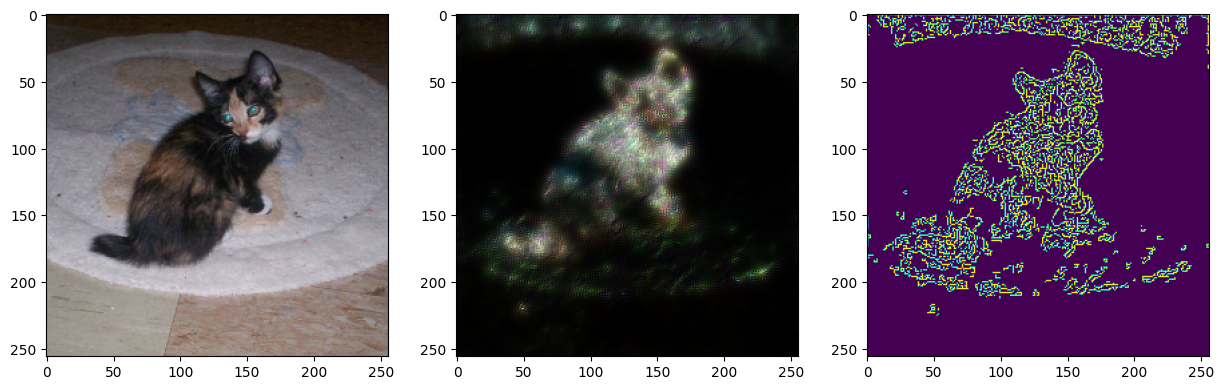

Cat: 1.0031/1.0000


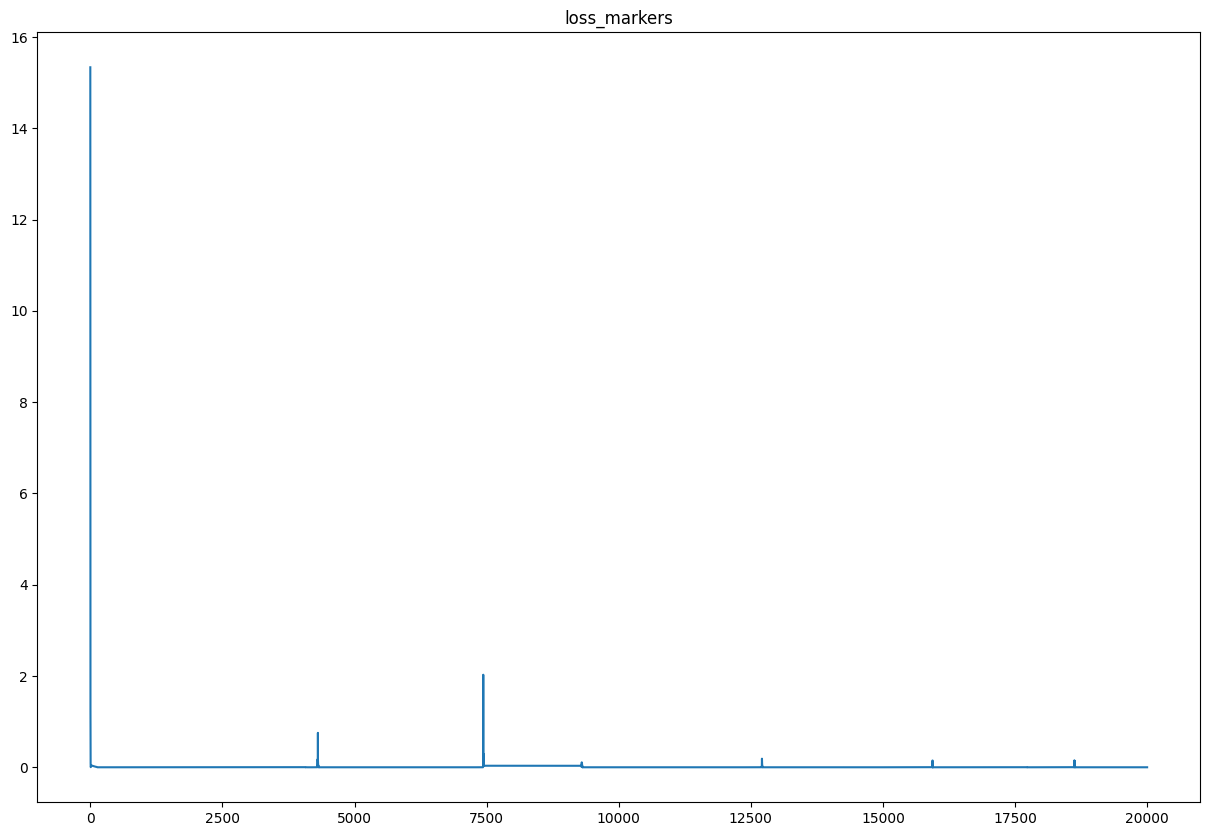

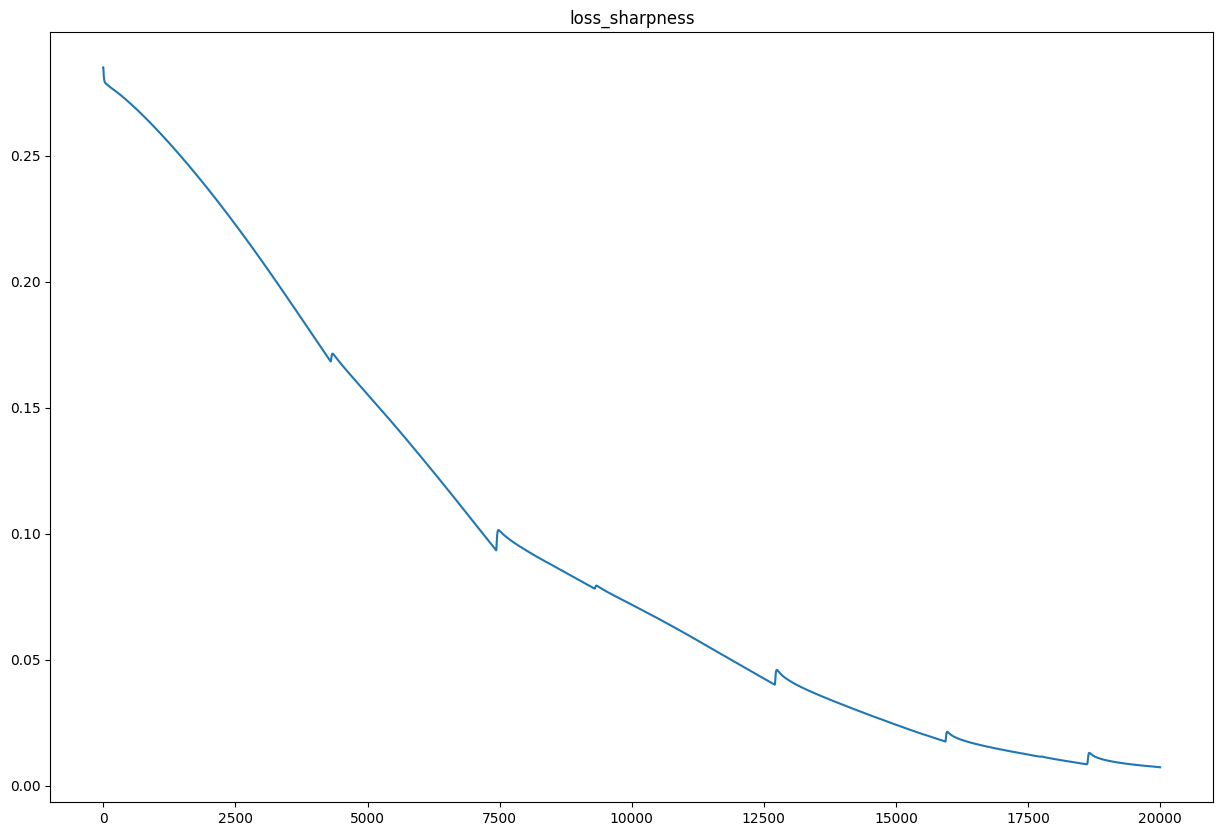

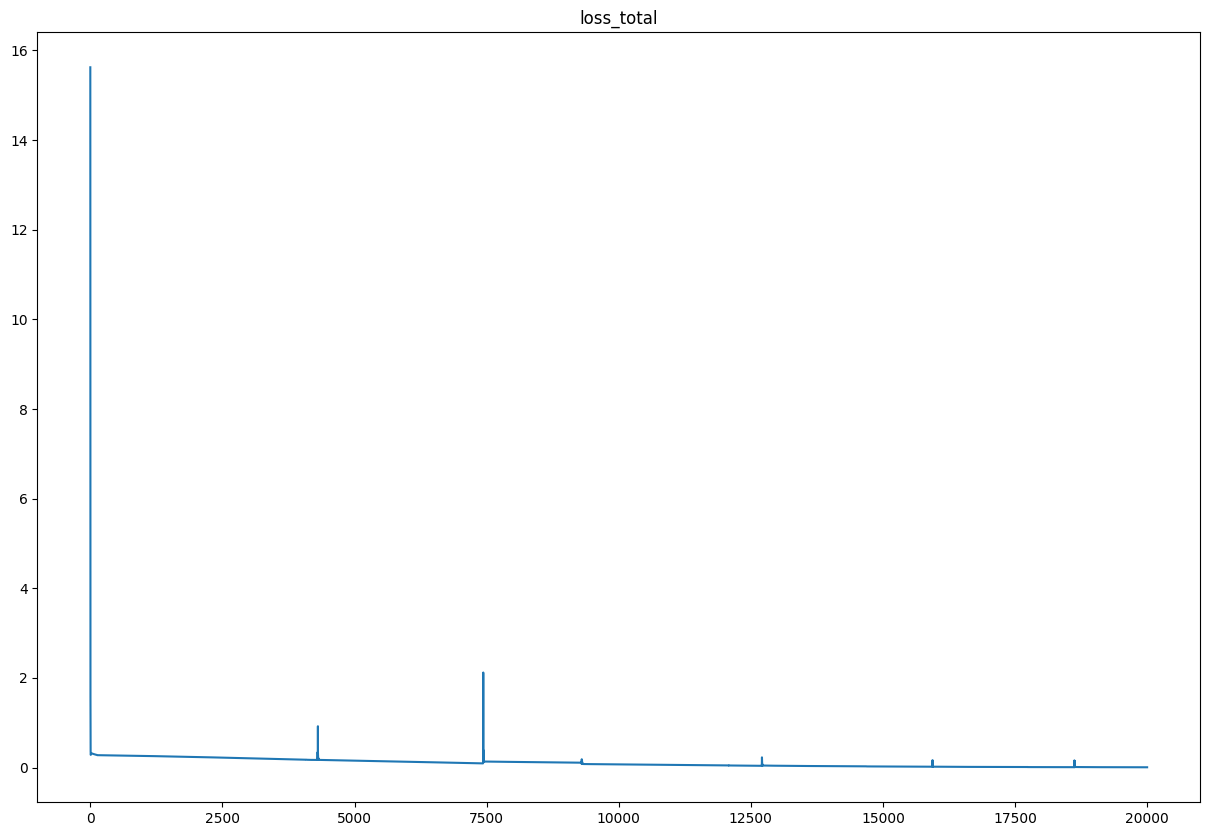

In [ ]:
print('Processing CNN model...')
history = process(model=model_cnn, image=img, \
                    # target_out=numpy.array(target_cnn, numpy.float32), \
                    weight_class=0.05, weight_blur=0.95, weight_sharpness=0.7, \
                    err_method='square', \
                    filename_video='cnn_transform_2.avi',
                    iterations=20000)

### Plot history

pyplot.plot(history[:, 0])
pyplot.title('loss_markers')
pyplot.show()
pyplot.plot(history[:, 1])
pyplot.title('loss_sharpness')
pyplot.show()
pyplot.plot(history[:, 0]+history[:, 1])
pyplot.title('loss_total')
pyplot.show()

Processing ResNetV2 model...
1/1 [==============================] - 0s 26ms/step
target_out.shape (1, 2)
image_init_blured.shape (1, 224, 224, 3)


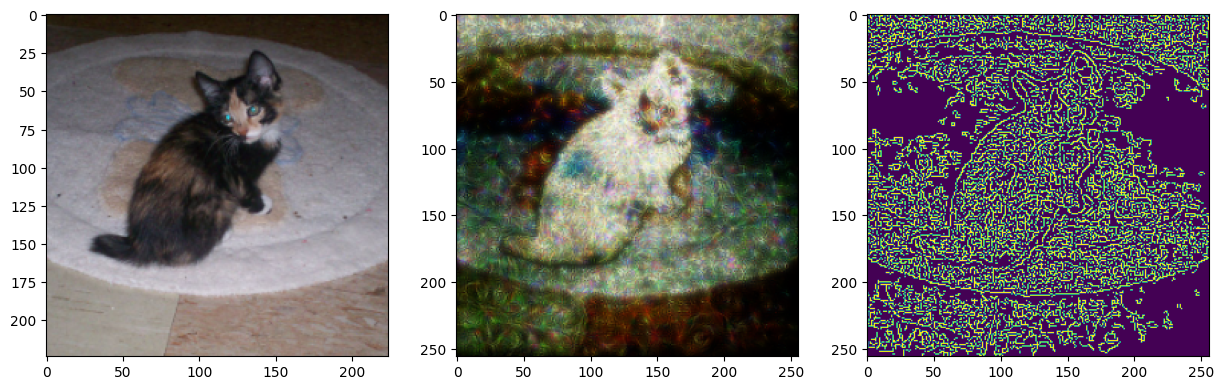

Cat: 0.9910/0.9999
(5000, 2)


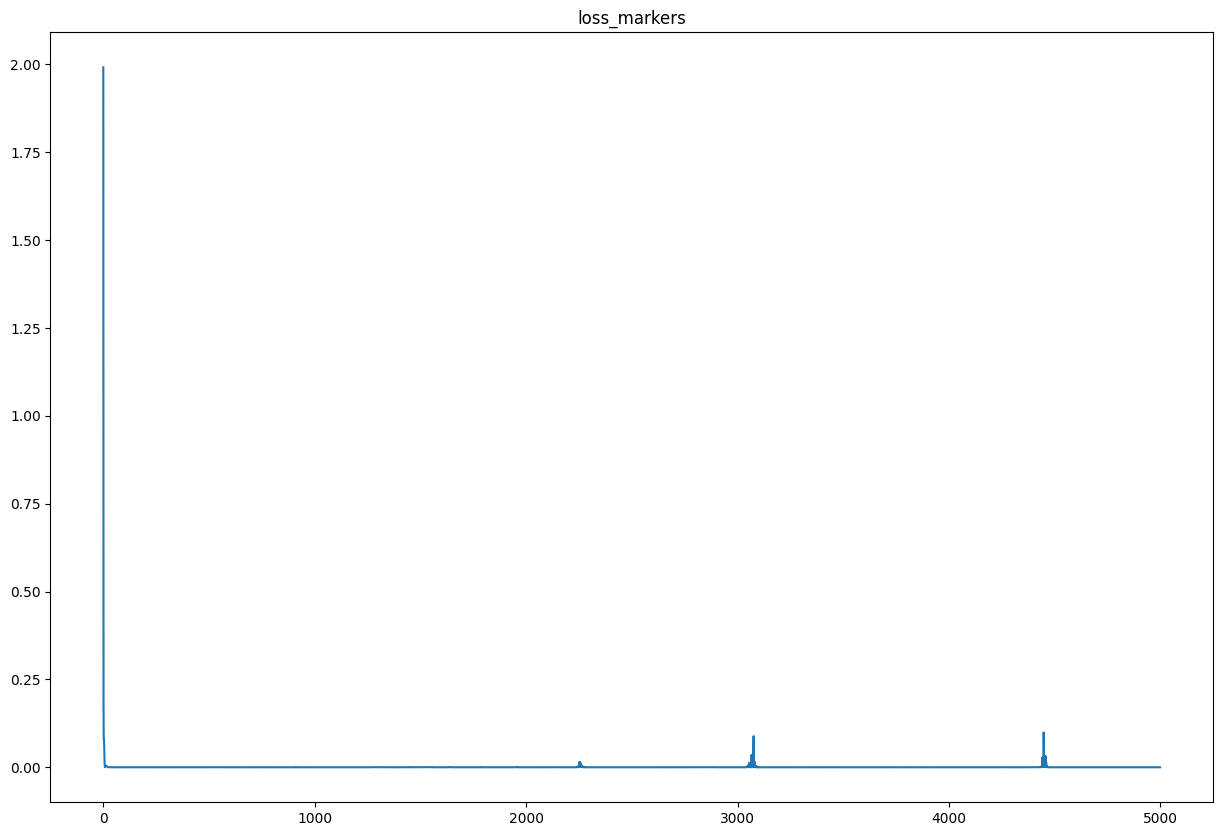

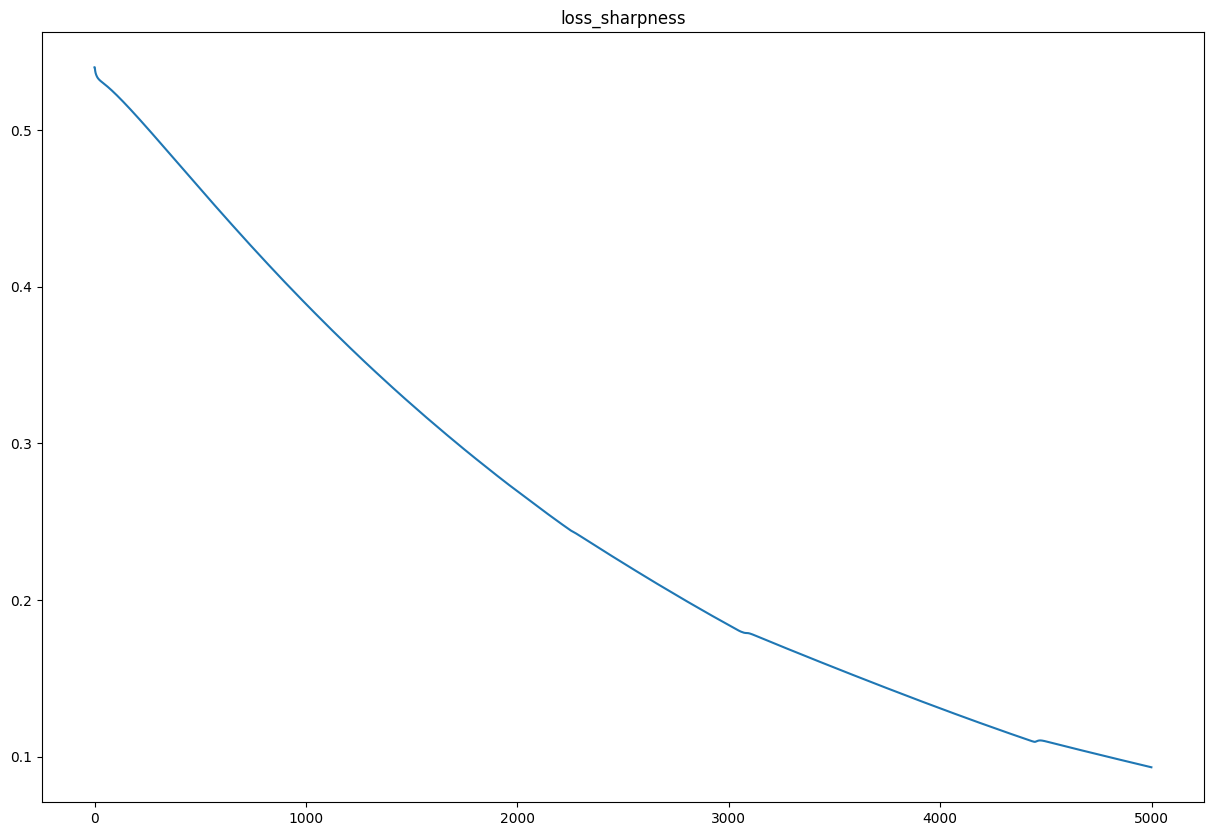

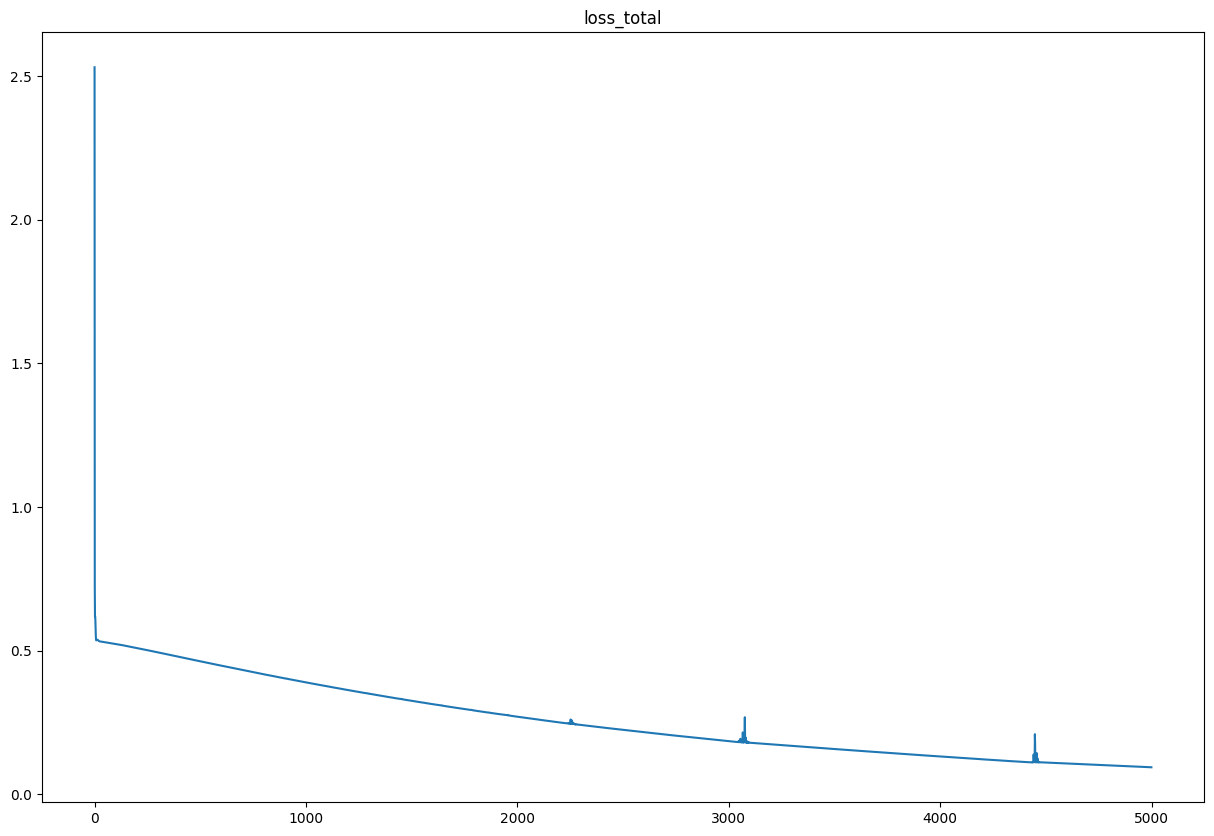

In [16]:
print('Processing ResNetV2 model...')
history = process(model=model_resnet, image=img_vgg19, \
                    # target_out=numpy.array(target_vgg19, numpy.float32), \
                    weight_class=0.1, weight_blur=0.9, weight_sharpness=0.4, \
                    err_method='square', \
                    filename_video='resnet_transform_2.avi',
                    iterations=5000)

### Plot history
print(history.shape)
pyplot.plot(history[:, 0])
pyplot.title('loss_markers')
pyplot.show()
pyplot.plot(history[:, 1])
pyplot.title('loss_sharpness')
pyplot.show()
pyplot.plot(history[:, 0]+history[:, 1])
pyplot.title('loss_total')
pyplot.show()

target.shape (1, 4, 4, 32)


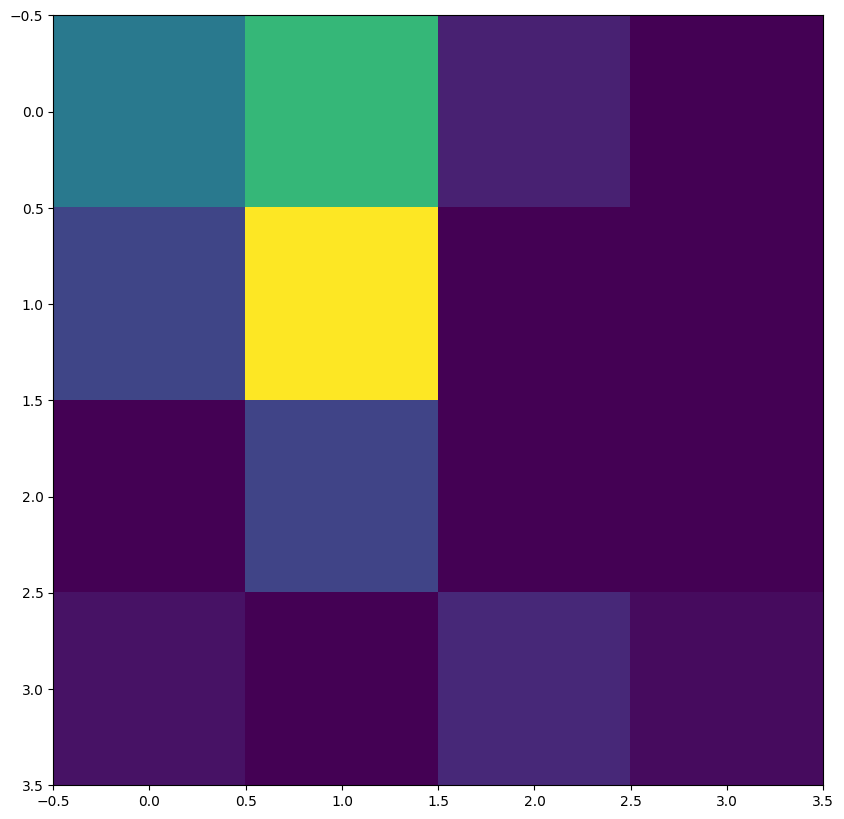

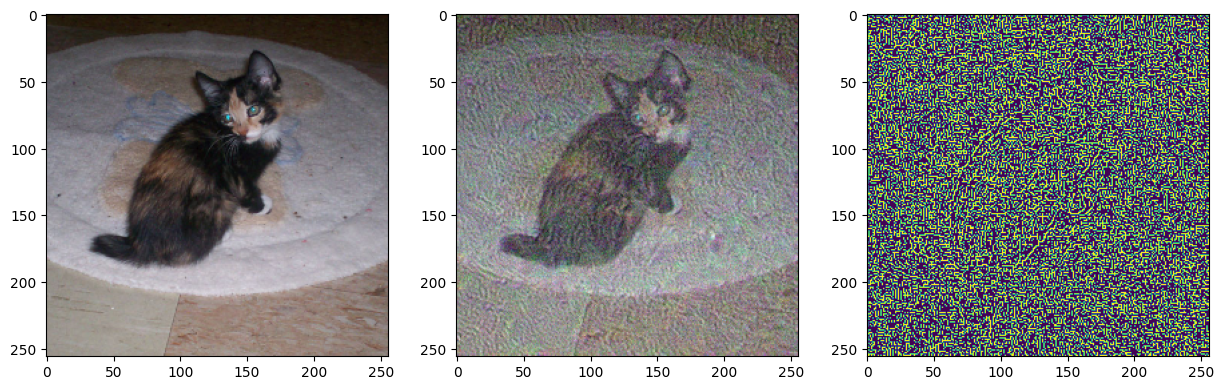

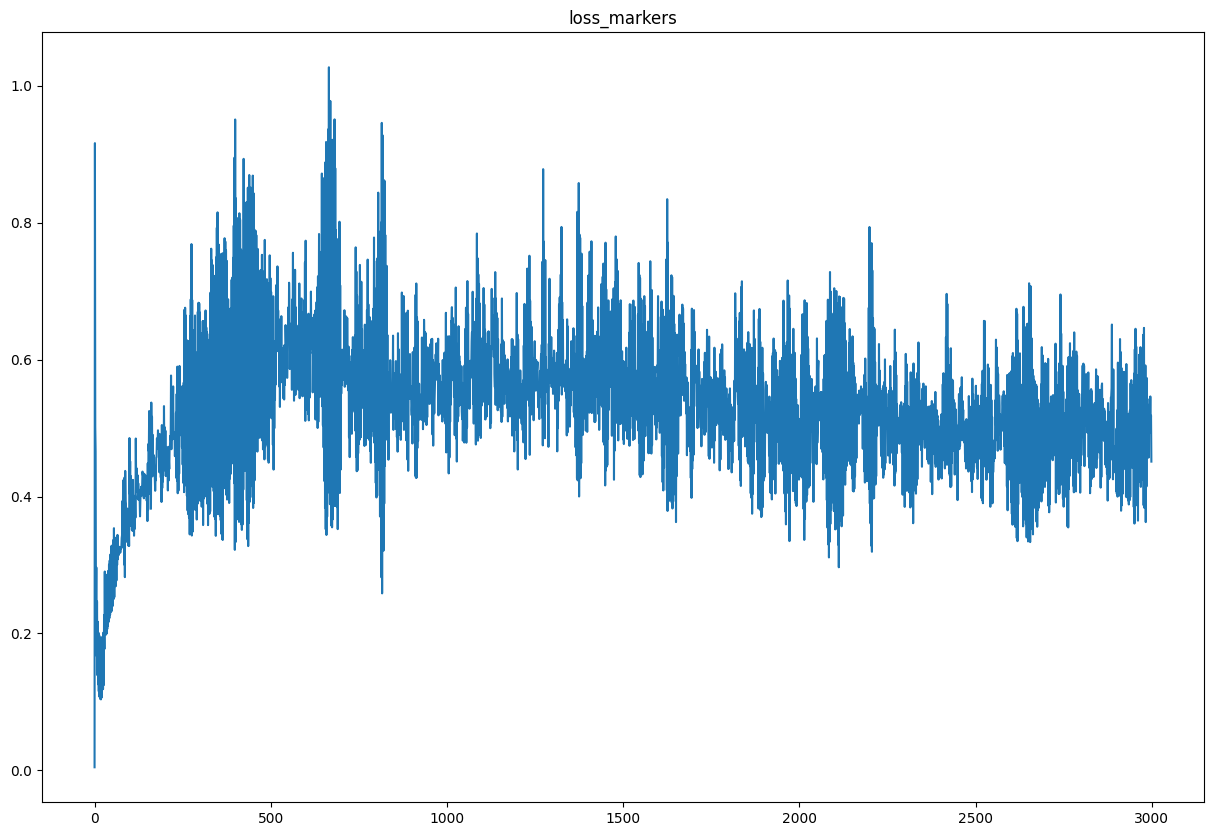

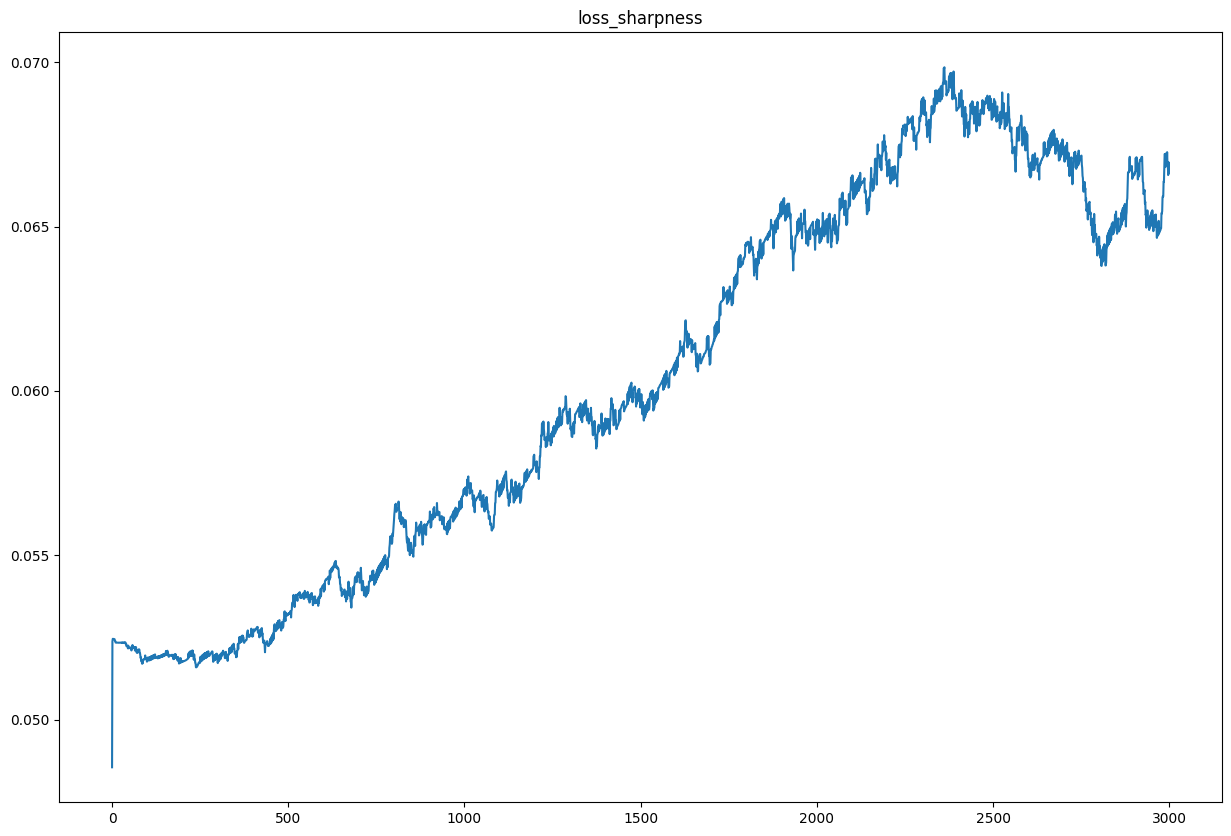

In [17]:
img = load_image('./data/PetImages/Cat/10050.jpg')

def process_greed_only(image, weight_class=5.0, weight_blur=1.0, err_method='abs'):
    history = list()
    model = tf.keras.Model(inputs=model_greed.input, outputs=model_greed.get_layer('concentrate_out_C').output)
    target = model(image).numpy()
    print('target.shape', target.shape)
    # target[0, :, :, 0] = 100.0
    target[0, :, :, 1] = 0.0
    # t_max = numpy.max(target)
    # target[target<t_max] = 0.0
    # target = target/ numpy.max(target)
    pyplot.imshow(target[0, :, :, 0])
    pyplot.show()
    image_init = image.copy()

    video_writer = cv2.VideoWriter('transform_greed_2.avi', 
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         10, (256, 256))

    # High frequency filter
    def make_tf_filter_3x3(filter_3x3):
        filter_tf = numpy.zeros(shape=(3, 3, 3, 3), dtype=numpy.float32)
        filter_tf[:, :, 0, 0] = filter_3x3
        filter_tf[:, :, 1, 1] = filter_3x3
        filter_tf[:, :, 2, 2] = filter_3x3
        return tf.constant(value=filter_tf, dtype=tf.float32)

    def make_tf_filter_5x5(filter_5x5):
        filter_tf = numpy.zeros(shape=(5, 5, 3, 3), dtype=numpy.float32)
        filter_tf[:, :, 0, 0] = filter_5x5
        filter_tf[:, :, 1, 1] = filter_5x5
        filter_tf[:, :, 2, 2] = filter_5x5
        return tf.constant(value=filter_tf, dtype=tf.float32)

    ## Filters 
    # sobel_h = numpy.array([[0.2, 0.6, 0.2],[0.0, 0.0, 0.0],[-0.2,-0.6,-0.2]], dtype=numpy.float32)
    # sobel_h = make_tf_filter_3x3(sobel_h)
    # sobel_w = numpy.array([[0.2, 0.0,-0.2],[0.6, 0.0,-0.6],[ 0.2, 0.0,-0.2]], dtype=numpy.float32)
    # sobel_w = make_tf_filter_3x3(sobel_w)

    sobel_h = numpy.array([[0.1, 0.2, 0.4, 0.2, 0.1], [0.1, 0.1, 0.2, 0.1, 0.1], [0.0, 0.0, 0.0, 0.0, 0.0], [-0.1,-0.1,-0.2,-0.1,-0.1], [-0.1,-0.2,-0.4,-0.2,-0.1]], dtype=numpy.float32)
    sobel_h = make_tf_filter_5x5(sobel_h)
    sobel_w = numpy.array([[0.1, 0.1, 0.0,-0.1,-0.1], [0.2, 0.1, 0.0,-0.1,-0.2], [0.4, 0.2, 0.0,-0.2,-0.4], [ 0.2, 0.1, 0.0,-0.1,-0.2], [ 0.1, 0.1, 0. ,-0.1,-0.1]], dtype=numpy.float32)
    sobel_w = make_tf_filter_5x5(sobel_w)

    s=1

    if err_method=='abs':
        err_type = tf.abs
    else:
        err_type = tf.square

    optimaser = tf.keras.optimizers.Adam(name='optimaser')# learning_rate=0.001, )

    image_init = tf.Variable(image_init, name='image_data')
    while True:
        for _ in range(10):
            with tf.GradientTape() as t:
                f = model(image_init)
                sh = tf.nn.conv2d(image_init, filters=sobel_h, strides=(1,1), padding='VALID')
                sw = tf.nn.conv2d(image_init, filters=sobel_w, strides=(1,1), padding='VALID')
                sh = err_type(sh)
                sw = err_type(sw)
                sh = tf.reduce_mean(sh)
                sw = tf.reduce_mean(sw)
                loss_markers = tf.reduce_mean(tf.square(target-f))*weight_class
                loss_sharpness = (sh+sw)*weight_blur
                loss = loss_markers + loss_sharpness #
            history.append( [loss_markers.numpy(), loss_sharpness.numpy()] )
            gradients = t.gradient(loss, image_init)
            # image_init.assign_sub(gradient*5.0)
            optimaser.apply_gradients(zip([gradients], [image_init]))
            image_init = tf.subtract(image_init, tf.reduce_min(image_init))
            image_init = image_init/tf.reduce_max(image_init)
            image_init = tf.Variable(image_init, name='image_data')
        if s<300:
            s=s+1
        else:
            break
        # class_of_init = model(image_init)
        # print(tf.reduce_max(gv).numpy())
        frame = (image_init.numpy()[0]*255).astype(dtype=numpy.uint8)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        class_weights = model_greed(image_init).numpy()[0]
        class_name = classes[numpy.argmax(class_weights)]
        cv2.putText(frame, f'{class_name}: {numpy.max(class_weights):.4f}', (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0))
        cv2.imshow('processing_image', frame)
        video_writer.write(frame)
        K = cv2.waitKey(1)
        if K==27:
            break
    video_writer.release()
    del video_writer
    # print(f.numpy())
    cv2.destroyAllWindows()

    pyplot.subplot(1, 3, 1)
    pyplot.imshow(image[0])
    pyplot.subplot(1, 3, 2)
    pyplot.imshow(image_init.numpy()[0]) #, vmin=0.0, vmax=1.0)
    pyplot.subplot(1, 3, 3)
    pyplot.imshow(cv2.Canny((image_init.numpy()[0, :, :, :]*255).astype(numpy.uint8), 10.0, 20.0)) #
    pyplot.show()
    return numpy.array(history), image_init.numpy()

history, generated_image = process_greed_only(img, weight_class=0.5, weight_blur=0.5, err_method='abs')

# resized = cv2.resize(generated_image[0], (270, 270))[4:260, 4:260, :]
# noised_img = resized + numpy.random.normal(0.0, 5.0/256, (1, 256, 256, 3))

# print(model_greed.predict(noised_img))
# print(model_mixer.predict(noised_img))
# print(model_cnn.predict(noised_img))

pyplot.plot(history[:, 0])
pyplot.title('loss_markers')
pyplot.show()
pyplot.plot(history[:, 1])
pyplot.title('loss_sharpness')
pyplot.show()